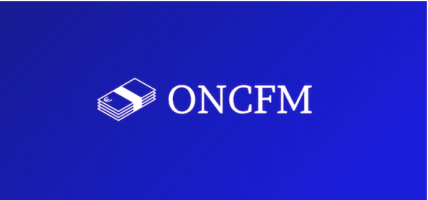

### Première Partie - Importation des librairies et préparation des dataframes

### I. Importation des librairies

In [1]:
# Importons les librairies dont nous auront besoin
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import cluster, metrics
from sklearn.cluster import KMeans
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_white , normal_ad
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib.collections import LineCollection

# Pour la regression logistique:
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score
from sklearn.linear_model import LogisticRegression

### II. Lecture des fichiers et préparation des dataframes

#### II.1.  Lecture des fichiers

In [2]:
# Récupérons notre fichier excel dans une variable
billets = pd.read_csv('billets.csv')

In [3]:
# Récupérons notre fichier excel dans une variable
billets_prod = pd.read_csv('billets_production.csv')

#### II.2.  Préparation des dataframes

In [4]:
# Affichons les 5 premières entrées pour avoir un aperçu de notre dataframe
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [5]:
# Affichons le nombre de lignes et de colonnes
billets.shape

(1500, 7)

*Le dataframe est composé de 1500 lignes et de 7 colonnes*

In [6]:
# Vérifions le type de données de notre dataframe
billets.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

<AxesSubplot:>

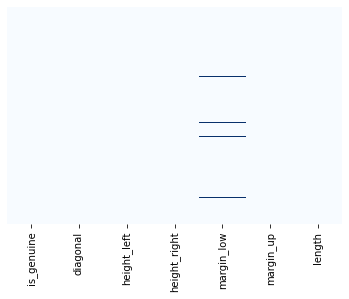

In [7]:
# Affichons les valeurs manquantes sur un graphique
sns.heatmap(billets.isnull(),yticklabels=False, cbar=False, cmap='Blues')

In [8]:
# vérifions les valeurs manquantes
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

*Seul le dataframe 'margin_low' contient des valeurs manquantes*

*Il y a des données manquantes, nous allons donc devoir faire une régression linéaire pour les combler et ne pas perdre d'informations.*

In [9]:
# cherchons les doublons du dataframe 
billets.duplicated().sum()

0

In [10]:
# Affichons les colonnes de notre dataframe
billets.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [11]:
# Imprimons un sommaire de notre dataframe
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [12]:
# Affichons les valeurs uniques par ordre d'apparition
billets["is_genuine"].unique()

array([ True, False])

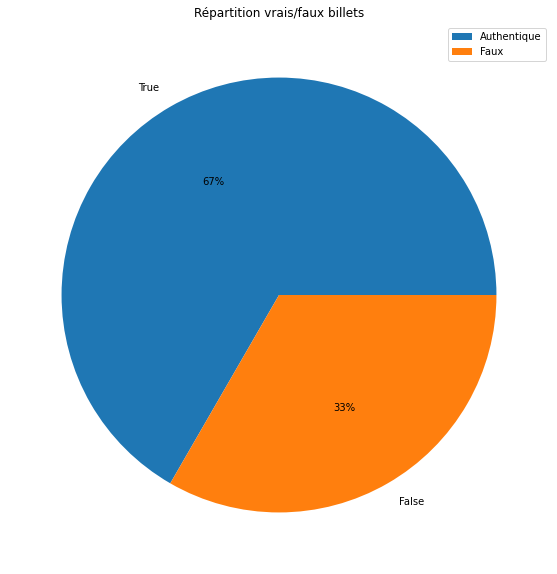

In [13]:
# Visualisons le volume des ventes à l'aide d'un diagrame en camembert
plt.figure(figsize=(10,10))

freqs = billets['is_genuine'].value_counts()
plt.pie(freqs,autopct='%1.0f%%',  labels=freqs.index)
plt.legend(['Authentique', 'Faux'])
plt.title('Répartition vrais/faux billets')
plt.show()

In [14]:
# Filtrons notre dataframe sur les billets authentiques
Authentique = billets[billets['is_genuine']==True]
Authentique.shape

(1000, 7)

In [15]:
# Affichons notre variable
Authentique

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
995,True,171.66,103.92,103.47,4.26,2.83,113.20
996,True,172.16,103.72,103.61,4.30,2.72,113.51
997,True,171.78,103.38,104.22,4.23,3.07,113.77
998,True,171.44,103.96,103.92,3.68,2.89,113.21


*1000 billets sont authentiques dans notre jeu de données*

In [16]:
# Affichons le nombre d'éléments par variable
Authentique.count()

is_genuine      1000
diagonal        1000
height_left     1000
height_right    1000
margin_low       971
margin_up       1000
length          1000
dtype: int64

In [17]:
# Filtrons notre dataframe sur les faux billets 
Faux = billets[billets['is_genuine']==False]
Faux.shape

(500, 7)

In [18]:
# Affichons notre variable
Faux

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1000,False,172.28,103.95,103.91,4.78,3.31,111.40
1001,False,171.92,103.86,104.30,4.96,3.13,111.29
1002,False,171.59,104.14,104.38,4.97,3.47,111.22
1003,False,172.02,104.33,104.33,5.19,3.21,111.99
1004,False,172.55,104.25,104.23,5.60,3.13,111.72
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


*500 billets sont faux dans notre jeu de données*

In [19]:
# Affichons le nombre d'éléments par variable
Faux.count()

is_genuine      500
diagonal        500
height_left     500
height_right    500
margin_low      492
margin_up       500
length          500
dtype: int64

In [20]:
# Regroupons nos variables 
billets.groupby(by='is_genuine').mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90116,104.19034,104.14362,5.215935,3.35016,111.63064
True,171.98708,103.94913,103.80865,4.116097,3.05213,113.20243


*En moyenne les faux  billets ont une :*

- Hauteur gauche plus élevée 
- Hauteur droite plus élevée 
- Marge de basse plus élevéé
- Marge haute plus élevée

*En moyenne les  billets authentiques ont une :*

- Diagonale plus élevée
- Longueur plus élevée

#### II.2.1  Visualisation (Boxplots)

<AxesSubplot:title={'center':'height_right'}, xlabel='is_genuine'>

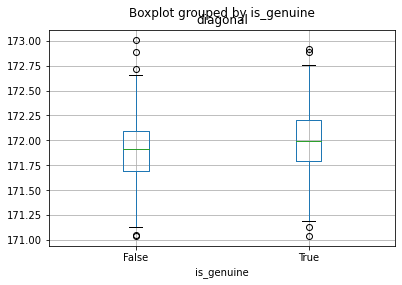

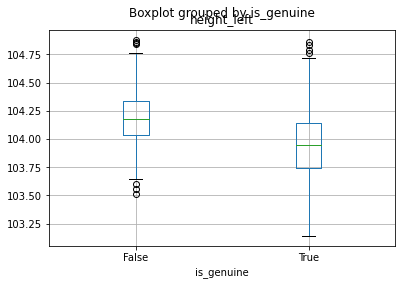

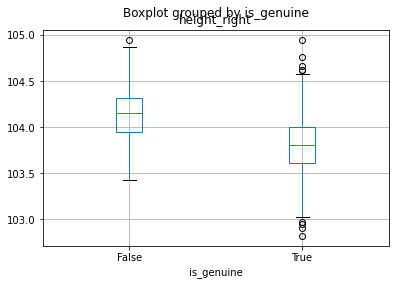

In [21]:
# Affichons les boxplots
billets.boxplot(column='diagonal',by='is_genuine')
billets.boxplot(column='height_left',by='is_genuine')
billets.boxplot(column='height_right',by='is_genuine')

<AxesSubplot:title={'center':'length'}, xlabel='is_genuine'>

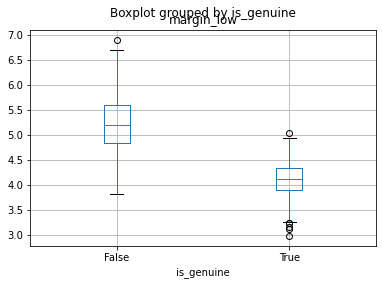

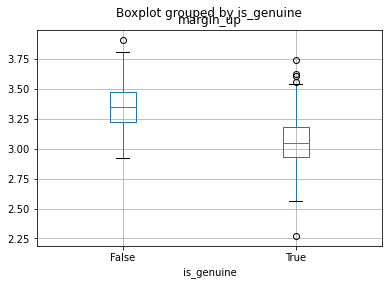

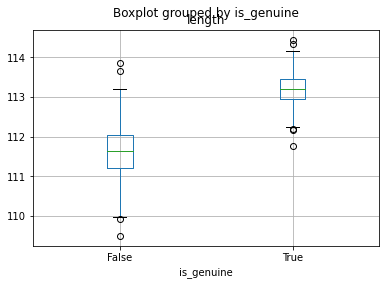

In [22]:
# Affichons les boxplots
billets.boxplot(column='margin_low',by='is_genuine')
billets.boxplot(column='margin_up',by='is_genuine')
billets.boxplot(column='length',by='is_genuine')

#### II.2.2 Visualisation ( Pairplots )

*Un pairplot nous permet de tracer des relations par paires entre les variables d'un ensemble de données. Cela crée une belle visualisation et nous aide à comprendre les données en résumant une grande quantité de données dans une seule figure. Ceci est essentiel lorsque nous explorons notre jeu de données et essayons de nous familiariser avec celui-ci*

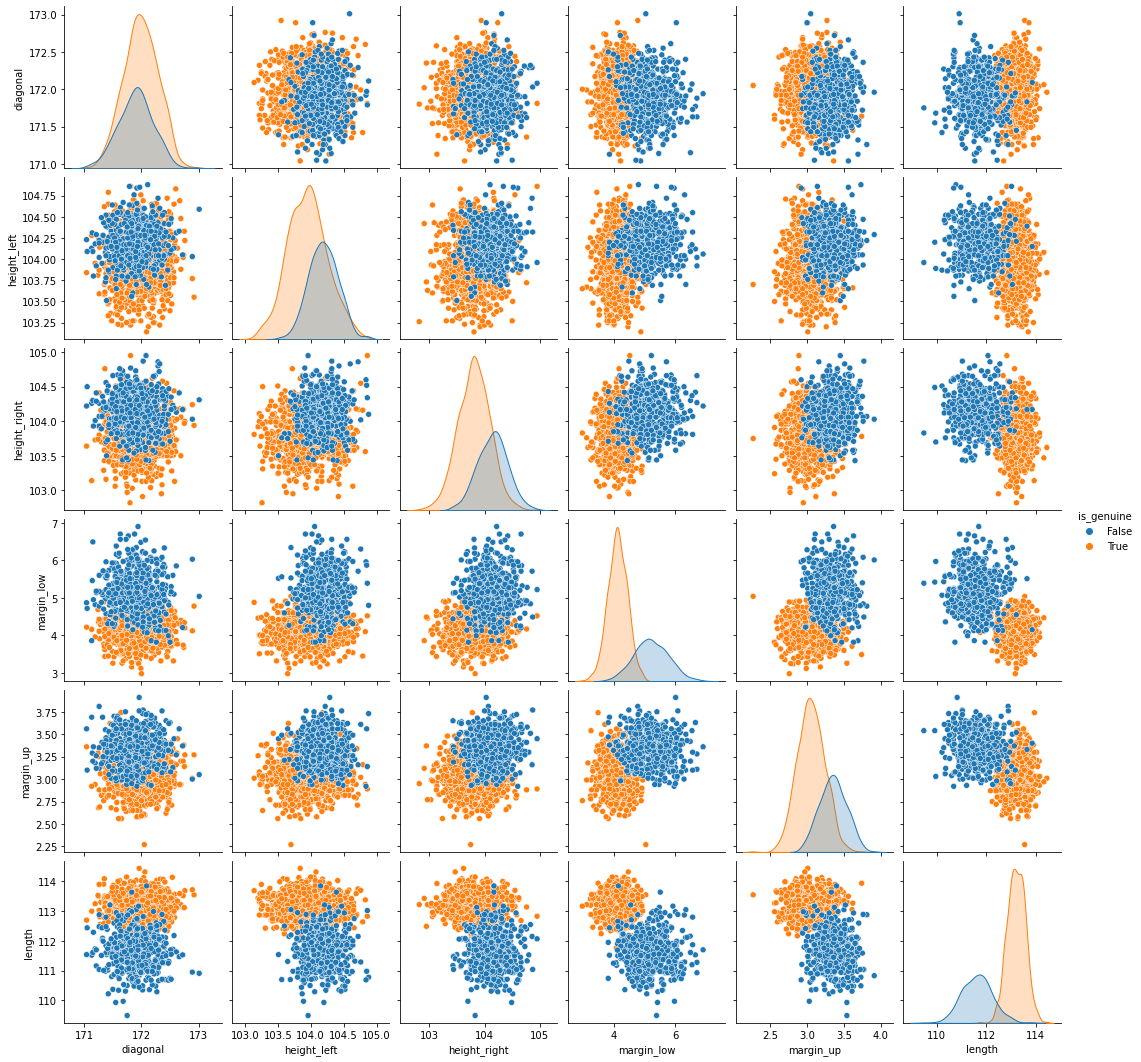

In [23]:
sns.pairplot(billets, hue="is_genuine")

*Les 2 variables qui séparent le nombre de faux et de vrais billets sont croisés*


*On observe une frontière, un trait qui sépare les vrais et les faux billets sur le croisement entre les 2 variables 'length' et 'margin_low'*

*Certains points paraissent particulièrement éloignés de leurs groupes, nous allons donc essayer d'identifier les outliers dans notre jeu de données. Les dimensions qui permettent vraiment de distinguer les vrais des faux billes sont length et margin_low. On retient donc ces variables comme meilleures candidates, mais on garde toutes les variables pour les analyses suivantes pour avoir une approche plus naïve des algorithmes. Dans un projet sans cahier des charges, la création de fonctions de classification reposant sur length et margin_low serait suffisante pour différencier les vrais des faux billets.*

#### II.2.3 Visualisation des outliers (boxplots)

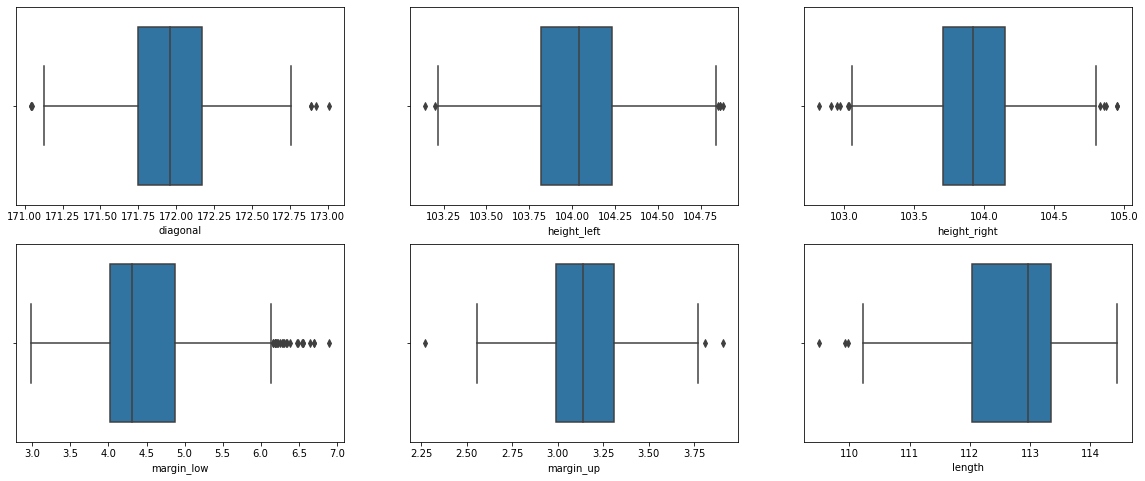

In [24]:
# Representation graphique des outliers:
a = 2  # nombre de lignes
b = 3  # nombre de colonnes
c = 1  # initialisation

fig = plt.figure(figsize=(20,8))

for i in billets.loc[:, billets.columns != "is_genuine"]:
    plt.subplot(a, b, c)
    #plt.title('{} (boxplot)'.format(i, a, b, c))
    plt.xlabel(i)
    sns.boxplot(x = billets[i])
    c = c + 1
plt.show()

#### II.3.  Matrice de corrélation

Text(0.5, 1.0, 'carte de correlation de Pearson')

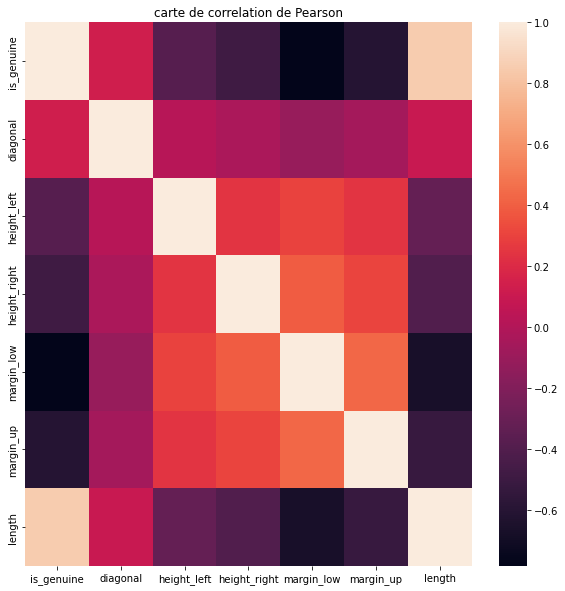

In [25]:
# Représentons la matrice de correlation
plt.figure(figsize=(10,10))
sns.heatmap(billets.corr()).set_title('carte de correlation de Pearson')

*Notons que la moitié supérieure du triangle de la matrice de corrélation est symétrique à la moitié inférieure du triangle. Ainsi, il n'est pas nécessaire que notre carte thermique affiche la matrice entière
Pour rendre cette matrice optimale, mieux lisible, nous allons retirer les valeurs qui se repètent.*

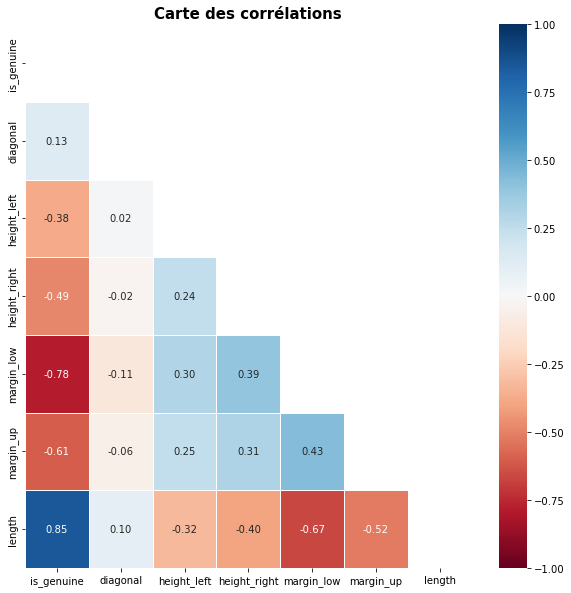

In [26]:
# Affichons une carte de correlations optimale avec les annotations
plt.figure(figsize=(10,10))
mask = np.triu(np.ones_like(billets.corr(), dtype=bool))
sns.heatmap(billets.corr(), mask=mask, center=0, cmap='RdBu', 
            linewidths=1, annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title('Carte des corrélations', fontsize = 15, fontweight='bold')
plt.show()

*Les variables fortement corrélées*

- is-genuine   Lenght = 0.85
- is-genuine   margin_low -0.78
- Lenght       margin_low = -0.67


*'Length' permet de prédire la valeur de 'margin_low' parce qu'elle apporte de l'information sur la nature du billet (vrai ou faux).
Les billets qui ont une plus petite longueur sont généralement des faux billets, et les faux billets ont généralement une marge plus grande.*

### Deuxième Partie - Régression linéaire multiple

### I. Régression linéaire 

La régression linéaire multiple est une solution permettant d'identifier les liens de corrélation entre un résultat (la variable dite expliquée) et plusieurs variables explicatives et indépendantes. 

une régression linéaire multiple projette le nuage de points dans un graphique à plusieurs dimensions. L'objectif étant de modéliser la présence de plusieurs variables explicatives. 

Pour interpréter une régression linéaire, il convient d'abord d'observer le nuage de points, sa forme, son étendue... Des ensembles de données peuvent très bien renvoyer à la même moyenne, au même écart-type et au même coefficient de corrélation. Cependant, les formes de ces ensembles peuvent être tout à fait différents. 

#### I.1. Préparation des données

In [27]:
billets_sans_isgenuine = billets[['diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length']]

# Separation des donnees manquantes des donnees non manquantes:
Reg_Lin_Train_billets = billets_sans_isgenuine.dropna()
Reg_Lin_Test_billets = billets_sans_isgenuine[billets_sans_isgenuine.isnull().any(axis=1)]

# Creation de X_train et Y_train:
x_train = Reg_Lin_Train_billets.drop("margin_low", axis=1)
y_train = Reg_Lin_Train_billets["margin_low"]

# Regression lineaire:
reg_lin = LinearRegression()
model_reg_lin = reg_lin.fit(x_train, y_train)

# Predictions:
x_train = Reg_Lin_Train_billets[["diagonal","height_left","height_right", "margin_up", "length"]]
Reg_Lin_Train_billets["margin_low_pred"] = reg_lin.predict(x_train)

C:\Users\moust\AppData\Local\Temp/ipykernel_21268/851296657.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_billets["margin_low_pred"] = reg_lin.predict(x_train)


#### I.2 Validation du modèle

#### I.2.1 Importation des données

*On importe les données, puis on régresse 'margin_low' en fonction des autres variables de l'échantillon*


In [28]:
# Instanciation:
reg_linb = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length", data = Reg_Lin_Train_billets)

# Calculs:
res_lin = reg_linb.fit()
print(res_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Tue, 21 Mar 2023   Prob (F-statistic):          2.60e-202
Time:                        06:51:33   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Summary va résumer les résultats de la fonction OLS

Aucune variable n'a un une P_valeur < 0.05

*Donc toutes les variables ont significatives*

#### I.2.2 Test d'hypothèses par analyse des résidus

#### I.2.2.1 Coefficient de détermination

R² est compris entre 0 et 1, où R²=0 signifie qu'il n'y a pas de relation linéaire entre les variables et R²=1 indique une relation linéaire parfaite. Dans notre cas, nous avons obtenu un score R² d'environ 0,477, ce qui signifie que 48 % de notre variable dépendante peuvent être expliqués à l'aide de nos variables indépendantes.


 *Cela signifie que l’équation de la droite de régression est capable de déterminer 48 % de la distribution des points*

*Le modèle explique 48 % de la variance*

#### I.2.2.2 Test de l’homoscédasticité

On appelle homscédasticité l'égalité de la variance d'une variable quelque soit l'échantillon qui y est puisé. Lorsque la variance diffère selon les échantillons, on parle alors d'hétéroscédasticité.

L'hétéroscédasticité est, en statistique, lorsque les erreurs ne sont pas constantes dans tout l'échantillon. Le terme est contraire à l'homoscédasticité.

C’est un test qui porte aussi sur le résidu .On va tester si la variance de notre résidu est
constante ou non à l’aide du test de White

{'Test Statistic': 109.86015196858523, 'p-value': 2.0828244990464866e-14, 'F-Statistic': 5.853731207796858, 'F-Test p-value': 4.974865092876405e-15}


C:\Users\moust\AppData\Local\Temp/ipykernel_21268/3093255625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_billets["residual"] = Reg_Lin_Train_billets["margin_low"] - Reg_Lin_Train_billets["margin_low_pred"]


Text(0.5, 1.0, 'Homoscédasticité')

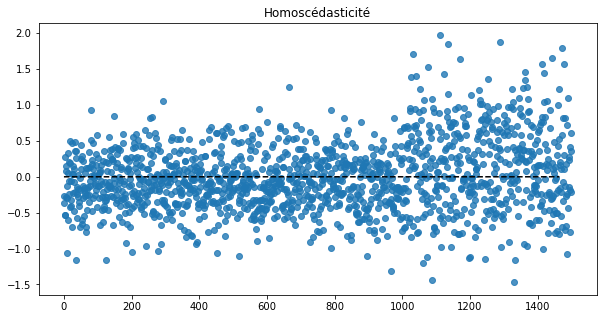

In [29]:
# Homoscedasticite

# Creation d'une colonne contenant les residus:
Reg_Lin_Train_billets["residual"] = Reg_Lin_Train_billets["margin_low"] - Reg_Lin_Train_billets["margin_low_pred"]

white_test = het_white(res_lin.resid, res_lin.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

# Graphique:
plt.subplots(figsize=(10, 5))
plt.scatter(x=Reg_Lin_Train_billets.index, y=Reg_Lin_Train_billets["residual"], alpha=0.8)
plt.plot(np.repeat(0, len(Reg_Lin_Train_billets.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

*La p-value est inférieure au seuil, on ne peut pas rejeter l'hypothèse nulle d'homoscédasticité.*

*L'hypothèse d'homoscédasticité de notre régression linéaire est donc considérée comme vérifiée au risque alpha 5 %*.

#### I.2.2.3 Normalité de la distribution des résidus

#### I.2.2.3.1 Omnibus

 Un test omnibus apparaît le plus souvent dans les modèles ANOVA et les modèles de régression linéaire multiple .

Prob(Omnibus) est un test statistique mesurant la probabilité que les résidus soient normalement distribués. Un 1 indiquerait une distribution parfaitement normale.

*La valeur de Prob(Omnibus) doit être proche de 1. Ici elle est nulle ce qui implique que l'hypothèse n'est pas verifée*

#### I.2.2.3.2 Durbin Watson (DW)

Le test de Durbin-Watson est un test statistique destiné à tester l'autocorrélation des résidus dans un modèle de régression linéaire

La statistique DW va de zéro à quatre, avec une valeur de 2,0 indiquant une autocorrélation nulle. Les valeurs inférieures à 2,0 signifient qu'il y a une autocorrélation positive et supérieures à 2,0 indiquent une 
autocorrélation négative.

*La valeur de la statistique de Durbin-Watson est de 1,893*

*1,893 étant inférieur à 2,0 =  autocorrélation positive*

*Il n'y a donc pas d'autocorrélation.*

#### I.2.2.3.3 Jarque-Bera 

Jarque-Bera est un test statistique qui sert à tester si la distribution est normale.
Les deux coefficients (Skewness et Kurtosis) permet de comparer une distribution
à une distribution normale, pour cela,

- *Skewness (S) mésure le dégré d'assymétrie de la distribution*. Lorsque, S est négatif,la distribution assymétrique vers la gauche, lorsque S est positif, la distribution  est assymétrique vers la droite. Lorsque s = 0 la distribution suit la loi normale.

- *Kurtosis mésure le dégré d'aplatissement de la distribution* : Lorsque k > 3 La distribution est pointue, lorsque k < 3 La distribution plus applanie que la loi normale, lorsque k = 3 La distribution suit la loi normale.

- Prob(JB) est la probabilité que la valeur de Jarque-Bera dépasse la valeur critique. Si la probabilité est inférieure à 5%, on rejette l’hypothèse nulle de la distribution normale. Si la probabilité est supérieure à 5 , on accepte l’hypothèse nulle de la distribution normale. Dans notre cas , la probabilité est de 0 donc on rejette l’hypothèse nulle.

*La valeur de Skewness est de 0.482 ce qui signifie que la dispersion est étalée
à droite.*

*La valeur de Kurtosis est de 3.801 ce qui signifie que la  la distribution est moins aplatie.*

*Prob(JB) 1.53e-21 < 0.05 ce qui signifie qu'on rejette l’hypothèse nulle de la distribution normale.*

*En conclusion, la distribution ne suit pas une loi normale*

#### I.2.2.3.4 Linéarité 

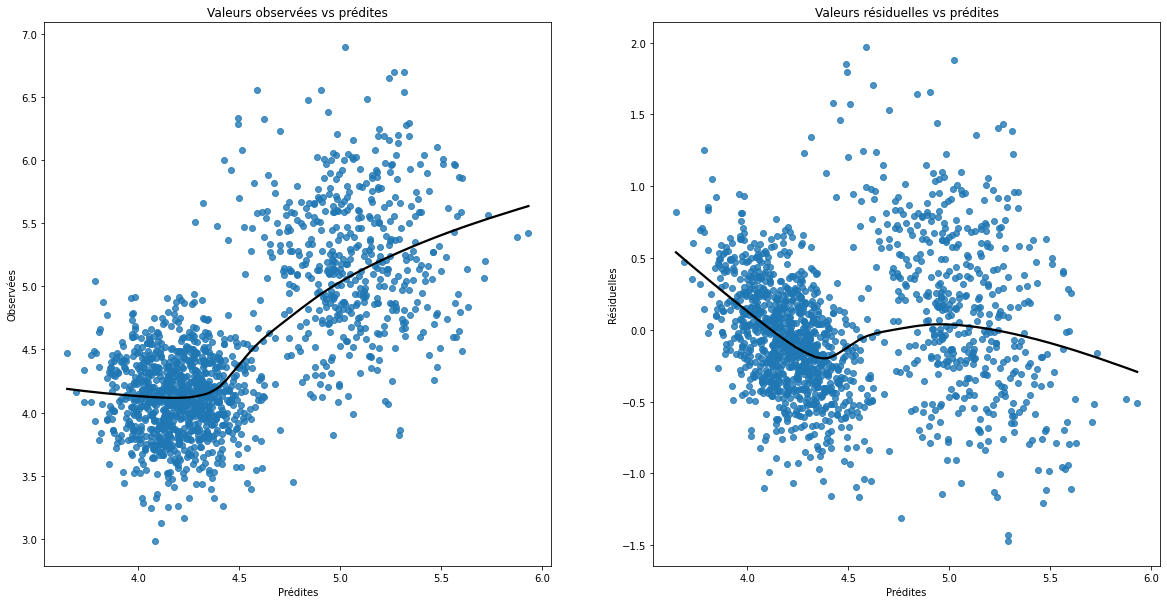

In [30]:
# Linearite:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(20,10))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'black'})
    ax[0].set_title("Valeurs observées vs prédites")
    ax[0].set(xlabel="Prédites", ylabel="Observées")

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'black'})
    ax[1].set_title("Valeurs résiduelles vs prédites")
    ax[1].set(xlabel="Prédites", ylabel="Résiduelles")
    
linearity_test(res_lin, Reg_Lin_Train_billets["margin_low"])

Une relation est linéaire si l'on peut trouver une relation entre X et Y de la forme Y=aX+b, c'est à dire si le nuage de point peut s'ajuster correctement à une droite.

Une relation est non-linéaire si la relation entre X et Y n'est pas de la forme Y=aX+b, mais de type différent (parabole, hyperbole, sinusoïde, etc). Le nuage de point présente alors une forme complexe avec des courbures.

*La relation n'est pas linéaire, l'hypothèse de linéarité n'est pas vérifiée.* 

#### I.2.2.4 Colinéarité des variables

VIF (Variance Inflation Factor) signifie Facteur d'Inflation de la Variance. Au cours de l'analyse de régression, VIF évalue si les facteurs sont corrélés les uns aux autres (multi-colinéarité), ce qui pourrait influencer les autres facteurs et réduire la fiabilité du modèle.Si un VIF est supérieur à 10, vous avez une multi-colinéarité élevée : la variation semblera plus grande et le facteur apparaîtra plus influent qu'il ne l'est. Si VIF est plus proche de 1, alors le modèle est beaucoup plus robuste, car les facteurs ne sont pas influencés par la corrélation avec d'autres facteurs.


VIF commence à 1 et n'a pas de limite supérieure

VIF = 1, pas de corrélation entre la variable indépendante et les autres variables

VIF supérieur à 5 ou 10 indique une forte multicolinéarité entre cette variable indépendante et les autres

In [31]:
# # Vérification de la colinéarité
variables = res_lin.model.exog
# Calculer le VIF
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686333,
 1.138260573608249,
 1.230114515556036,
 1.4044037781843624,
 1.576950145366581]

*Puisqu’il n’y a aucune valeur VIF supérieure à 10, il est tentant d’affirmer qu’il n’y a pas de multicolinéarité.*

En conclusion : Le modèle par la regréssion linéaire n'est pas pertinent parce que sur les 3 hypothèses rien que 2 sont vérifiés à savoir :
    
    - Normalité de la distribution des résidus : Avec JB, Omnibus la distribution ne suit pas une loi normale
        
    - Homocédasticité : L'hypothèse d'homoscédasticité de notre régression linéaire est donc considérée comme vérifiée au risque alpha 5 %.
    
    - Colinéarité : Aucune valeur VIF supérieure à 10, il est tentant d’affirmer qu’il n’y a pas de multicolinéarité.

#### I.3. Identification des individus atypiques et influents (iai)

In [32]:
# Identification des individus atypiques et influents (iai), preambulle:
student_resid = res_lin.get_influence().resid_studentized_external
(cooks, p_val_cooks) = res_lin.get_influence().cooks_distance
(dffits, p_val_dffits) = res_lin.get_influence().dffits
leverage = res_lin.get_influence().hat_matrix_diag

C:\Users\moust\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Résidus studentisés')

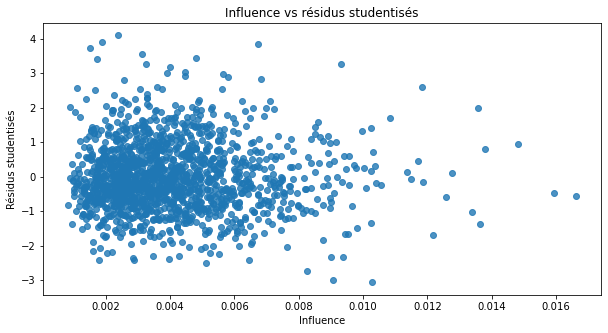

In [33]:
# Graphique:

plt.subplots(figsize=(10, 5))
sns.regplot(leverage, res_lin.resid_pearson, fit_reg=False)
plt.title("Influence vs résidus studentisés")
plt.xlabel("Influence")
plt.ylabel("Résidus studentisés")

In [34]:
# Creation d'un dataframe
iai = pd.concat([Reg_Lin_Train_billets["margin_low"], res_lin.get_influence().summary_frame()], axis = 1)
iai = iai.rename(columns={"hat_diag": "leverage"})                                               #hat_diag = leverage donc on change le nom
iai.head()

,margin_low,dfb_Intercept,dfb_diagonal,dfb_height_left,dfb_height_right,dfb_margin_up,dfb_length,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,4.52,0.038028,0.011150,-0.040676,-0.050650,0.028339,-0.018016,0.000894,-0.563593,0.016606,-0.073239,-0.563461,-0.073221
1,3.77,-0.047734,0.031782,0.040802,0.006819,0.006051,0.006096,0.000597,-0.769710,0.006015,-0.059874,-0.769603,-0.059866
2,4.40,-0.028752,0.034142,0.027975,-0.020340,-0.010975,-0.001295,0.000457,0.572488,0.008298,0.052367,0.572356,0.052355
3,3.62,-0.031981,0.060924,0.001406,-0.016400,0.006425,-0.029579,0.000936,-1.118681,0.004467,-0.074934,-1.118778,-0.074940
4,4.04,-0.025618,0.021411,-0.027128,0.056039,-0.049448,-0.009670,0.001171,-1.121058,0.005558,-0.083813,-1.121157,-0.083821


influence.resid_studentized_external : résidus studentisés en externe, permettent de détecter les valeurs aberrantes, observations qui possèdent des valeurs extrêmes sur l'ensemble des prédicteurs ou la variable dépendante.
    
influence.cooks_distance : distance de Cook, utilisée pour estimer l'influence d'une donnée lors de l'utilisation de méthodes des moindres carrés.
    
influence.dffits : DFFITS statistics ("difference in fit(s)"), c'est une méthode de diagnostique de l'influence d'un point dans une régression.
    
influence.hat_matrix_diag : la diagonale de projection, ou "hat". La mtatrice hat décrit l'influence de chaque valeur dépendante sur chaque valeur estimée. Sa diagonale correspond aux 'leverages', qui décrivent l'influence de chaque valeur sur l'estimation pour la même observation.

#### I.3.1 Identification des individus atypiques

In [35]:
# Studentisation des residus:
std_res = iai.student_resid
print ("résidus studentisés:\n", std_res.describe())

# Individus atypiques:
outlier = pd.DataFrame((iai["margin_low"][abs(std_res) > 2]))
print(outlier.count())

résidus studentisés:
 count    1463.000000
mean        0.000133
std         1.001419
min        -3.087577
25%        -0.660578
50%        -0.086814
75%         0.570403
max         4.127099
Name: student_resid, dtype: float64
margin_low    72
dtype: int64


*Il existe 72 individus sont atypiques*

#### I.3.2 Identification des individus à forte influence

In [36]:
# Identification des individus à forte influence:
k_reg_lin = 5                                       # k = nombre de variables predictives pour la regression lineaire +1 si on a une constante
n_reg_lin = 1500                                    # n = nombre d'observations
lev_thr = ((2*k_reg_lin)+2)/n_reg_lin               #=0.047 Seuil (threshold), toutes valeurs au dessus aura une forte influence

print(iai["leverage"].describe())

hg_leverage = iai["margin_low"][abs(iai["leverage"]) > lev_thr]
print("nombre d'individus à forte influence:", hg_leverage.count())

count    1463.000000
mean        0.004101
std         0.002134
min         0.000840
25%         0.002561
50%         0.003645
75%         0.005140
max         0.016606
Name: leverage, dtype: float64
nombre d'individus à forte influence: 79


*Il existe 79 individus à forte influence*

#### I.3.3 Identification des individus atypiques à forte influence

In [37]:
# Identification des individus atypiques a forte influence:
outliers_hg_lev =pd.merge(outlier,hg_leverage, left_index=True, right_index=True)
print(outliers_hg_lev.count())
print(outliers_hg_lev)

margin_low_x    7
margin_low_y    7
dtype: int64
      margin_low_x  margin_low_y
664           5.04          5.04
965           3.45          3.45
1074          4.36          4.36
1089          3.86          3.86
1199          4.49          4.49
1329          3.82          3.82
1478          6.08          6.08


*Il y a  7 individus à la fois influents et atypiques*

#### I.3.4 Suppression des individus atypiques à forte influence

In [38]:
# Suppression des iai:
billets_sup_iai = billets_sans_isgenuine.drop(outliers_hg_lev.index)

#### I.3.5 Regression linéaire

In [39]:
# Instanciation:
reg_lin_c = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length", data = billets_sup_iai)

# Calculs:
model_reg_lin_b = reg_lin_c.fit()
print(model_reg_lin_b.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     282.2
Date:                Tue, 21 Mar 2023   Prob (F-statistic):          5.39e-211
Time:                        06:51:49   Log-Likelihood:                -972.21
No. Observations:                1456   AIC:                             1956.
Df Residuals:                    1450   BIC:                             1988.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       24.2866      9.516      2.552   

- Le R² augmente légèrement (0.47 à 0.49).

- Les p_valeurs restent inférieurs à 0,05, donc ils restent significatifs

-  DW passe de 1,893 à 1,906

- Skew passe de 0,482 à 0,506 

- Kurtosis passe de 3,801 à 3,720

- JB passe de 95,802 à 93,636

Les coefficients et leurs statistiques restent eux globalement inchangés :
Il n'est donc plus utile de recommencer les tests

*Le nombre d'individus influents et atypiques est faible (7/1463), ils n'influencent finalement pas tant le jeu de données et leur suppression n'apporte pas beaucoup au modèle, la décision est prise de continuer avec eux tout en gardant leur présence à l'esprit. Il est toujours possible d'utiliser, si nécessaire, 'billets_sup_iai' à la place de 'billets'.*

#### I.4. Application du modèle

Nous allons remplacer les valeurs manques de la variable 'margin_low' par les valeurs prédites

In [40]:
# Créons une variable qui va regrouper les Nan de 'margin_low'
billets_na = billets_sans_isgenuine[billets_sans_isgenuine['margin_low'].isna()]

In [41]:
# Créons une variable en filtrant les colonnes 
x_na = billets_na[["diagonal","height_left","height_right", "margin_up","length"]]

In [42]:
# Affichons notre variable précédente
x_na

,diagonal,height_left,height_right,margin_up,length
72,171.94,103.89,103.45,3.25,112.79
99,171.93,104.07,104.18,3.14,113.08
151,172.07,103.80,104.38,3.02,112.93
197,171.45,103.66,103.80,3.62,113.27
241,171.83,104.14,104.06,3.02,112.36
251,171.80,103.26,102.82,2.95,113.22
284,171.92,103.83,103.76,3.23,113.29
334,171.85,103.70,103.96,3.00,113.36
410,172.56,103.72,103.51,3.12,112.95
413,172.30,103.66,103.50,3.16,112.95


In [43]:
# prédictions des données de 'margin_low'
margin_low_pred = res_lin.predict(x_na)
margin_low_pred

72      4.318525
99      4.393668
151     4.410457
197     4.319014
241     4.650617
251     3.803308
284     4.179736
334     4.127442
410     4.135034
413     4.160539
445     4.177420
481     3.768554
505     4.058764
611     4.298047
654     4.160607
675     4.094065
710     4.439846
739     4.470650
742     4.341643
780     4.080414
798     3.614306
844     4.371811
845     4.093621
871     4.249629
895     3.893748
919     3.746333
945     4.237415
946     4.710533
981     4.137780
1076    5.050277
1121    4.802145
1176    5.067584
1303    5.047570
1315    4.778967
1347    5.726993
1435    5.185862
1438    5.140043
dtype: float64

In [44]:
# Remplacons les valeurs manquantes de la variable 'margin_low' par les valeurs prédites
billets_sans_isgenuine['margin_low'] = billets_sans_isgenuine['margin_low'].fillna(margin_low_pred)
billets_sans_isgenuine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1500 non-null   float64
 1   height_left   1500 non-null   float64
 2   height_right  1500 non-null   float64
 3   margin_low    1500 non-null   float64
 4   margin_up     1500 non-null   float64
 5   length        1500 non-null   float64
dtypes: float64(6)
memory usage: 70.4 KB


C:\Users\moust\AppData\Local\Temp/ipykernel_21268/2250274756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billets_sans_isgenuine['margin_low'] = billets_sans_isgenuine['margin_low'].fillna(margin_low_pred)


<AxesSubplot:>

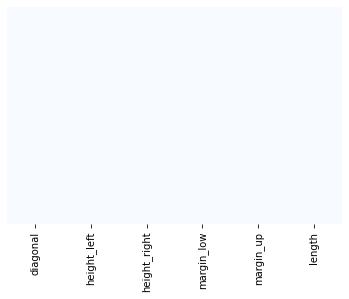

In [45]:
# Affichons les valeurs manquantes sur un graphique
sns.heatmap(billets_sans_isgenuine.isnull(),yticklabels=False, cbar=False, cmap='Blues')

*Nous n'avons plus 1463 valeurs mais bien 1500* 
*Les 'NAN' de notre variable margin_low ont été remplacés*

*Et voilà, vous avez vu en pratique comment réaliser une régression linéaire multiple pour déterminer et prédire la concentration des faux et vrais billets. Dans la prochaine partie, vous aborderez l'ACP et le Kmeans.*

In [46]:
# Affichons notre dataframe avec isgenuine' et contenant les NAN remplacées de 'margin_low'
billets_sans_isgenuine 

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


In [47]:
# Affichons le dataframe de départ
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [48]:
# Faisons un concat puis supprimons les colles de 'billets' tout en gardant 'is_genuine'
billets_avec_isgenuine = pd.merge(billets,billets_sans_isgenuine, left_index=True, right_index=True)
billets_avec_isgenuine

,is_genuine,diagonal_x,height_left_x,height_right_x,margin_low_x,margin_up_x,length_x,diagonal_y,height_left_y,height_right_y,margin_low_y,margin_up_y,length_y
0,True,171.81,104.86,104.95,4.52,2.89,112.83,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25,172.06,104.28,104.06,5.17,3.46,112.25


In [49]:
billets_avec_isgenuine.isnull().sum()

is_genuine         0
diagonal_x         0
height_left_x      0
height_right_x     0
margin_low_x      37
margin_up_x        0
length_x           0
diagonal_y         0
height_left_y      0
height_right_y     0
margin_low_y       0
margin_up_y        0
length_y           0
dtype: int64

In [50]:
# Affichons les colonne de notre nouvelle variable
# x = billets, y = billets_sans_genuine
billets_avec_isgenuine.columns

Index(['is_genuine', 'diagonal_x', 'height_left_x', 'height_right_x',
       'margin_low_x', 'margin_up_x', 'length_x', 'diagonal_y',
       'height_left_y', 'height_right_y', 'margin_low_y', 'margin_up_y',
       'length_y'],
      dtype='object')

In [51]:
# Supprimons les colonnes x
columns = ['diagonal_x', 'height_left_x', 'height_right_x',
       'margin_low_x', 'margin_up_x', 'length_x']
billets_avec_isgenuine.drop(columns, inplace=True, axis=1)

In [52]:
# Vérifions les valeurs manquantes
billets_avec_isgenuine.isnull().sum()

is_genuine        0
diagonal_y        0
height_left_y     0
height_right_y    0
margin_low_y      0
margin_up_y       0
length_y          0
dtype: int64

In [53]:
#Renommons les titres
billets_avec_isgenuine.rename(columns={'diagonal_y':'diagonal','height_left_y':'height_left','height_right_y':'height_right','margin_low_y':'margin_low','margin_up_y':'margin_up','length_y':'length'},inplace=True)
billets_avec_isgenuine

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


### Troisième Partie - Partitionnement des données

### I.  Analyse en composantes principales (ACP)

L'analyse en composantes principales (ACP)  vise à réduire le nombre de variables appliquées à des individus, pour simplifier les observations tout en conservant un maximum d’informations. Seules une, deux ou trois variables dites "composantes principales" sont conservées.

Il y a deux manières pour déterminer le nombre d’axes à prendre en compte :

- Un critère “absolu” : ne retenir que les axe dont les valeurs propres sont supérieures à 1 (c’est le critère de Kaiser).
- Un critère “relatif” : retenir les valeurs propres qui “dominent” les autres, en se référant au graphique en barres des valeurs propres (“screeplot”, chez les Anglo-saxons). 

#### I.1.  Préparation des données pour l'ACP

In [54]:
# Mettons notre variable qualitative en index
billets_avec_isgenuine_ind = billets_avec_isgenuine.set_index('is_genuine')

In [55]:
# Affichons notre dataframe modifié
billets_avec_isgenuine_ind.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
True,171.81,104.86,104.95,4.52,2.89,112.83
True,171.46,103.36,103.66,3.77,2.99,113.09
True,172.69,104.48,103.50,4.40,2.94,113.16
True,171.36,103.91,103.94,3.62,3.01,113.51
True,171.73,104.28,103.46,4.04,3.48,112.54


Afin de préparer nos données pour l'ACP,

On créé d'abord un objet (nommé ici pca) qui va contenir le résultat de l'ACP. 

Dans la fonction PCA(), on pourra aussi indiquer les paramètres tels que le nombre de composants à retenir (n_components - ici on garde tout).
Ensuite, on ajuste (fit en anglais) sur des données avec la fonction fit() de l'objet précédemment créé. Dans cette fonction, nous devons donc passer les données à utiliser (variables uniquement quantitatives).

Si l'on souhaite une ACP normée, il nous faut standardiser les données, avec par exemple la fonction scale() du sous-module preprocessing. Pour cela, on importe les données et on les centre-réduit avant d'appliquer notre ACP.

In [56]:
# préparation des données pour l'ACP

# choix du nombre de composantes à calculer
n_comp = 6

# import de l'échantillon
data = billets_avec_isgenuine_ind

# selection des colonnes à prendre en compte dans l'ACP
data_pca = billets_avec_isgenuine_ind[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]

# préparation des données pour l'ACP
X = data_pca.values
names = data.index # ou data.index pour avoir les intitulés
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA()
pca.fit(X_scaled)

PCA()

####  Variance expliquée

L'objet pca comprend maintenant un certain nombre d'objets et de fonctions. Le premier objet est le tableau des variances expliquées (explained_variance_ - proportionnelles aux valeurs propres) par chaque dimension, et le ratio (proportion) de variance expliquée par dimension (explained_variance_ratio_).

In [57]:
pca.explained_variance_ratio_.cumsum()

array([0.43288253, 0.60244869, 0.73269932, 0.85094803, 0.94697507,
       1.        ])

 #### I.2.  Application 

 #### I.2.1  Eboulis des valeurs propres (Scree plot)

Le graphique suivant nous donne l'évolution de la variance expliquée en fonction du nombre de composantes

Scree plot (pour le test du coude) est une autre technique graphique utile dans la rétention des Composantes principales. Nous devrions garder les Composantes principales là où il y a un changement brusque dans la pente de la ligne reliant les Composantes principales adjacentes. 

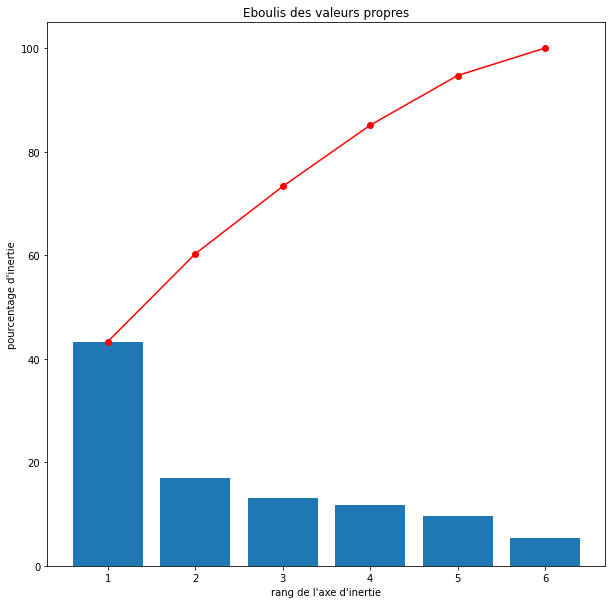

In [58]:
# Retenons les valeurs propres qui “dominent” 
# Représentation de la variance expliquée 
scree = pca.explained_variance_ratio_*100
plt.figure(figsize=(10, 10))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')

    
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show()

*Le changement brusque s'opère au niveau de la deuxième composante.*

*Idéalement, les deux premières valeurs propres correspondent à un % élevé de la variabilité soit (60,24 %),
si bien que la représentation sur les deux premiers axes factoriels est de bonne qualité.*

*Les deux premières composantes absorbent bien plus que de la moitié de la variabilité*

#### I.2.2  Cercle des corrélations 

 Recherche des groupes de variables fortement corrélées deux à deux entre elles, l'objectif est de pouvoir les synthétiser par une variable unique F1 et F2 (nos composantes principales).

Le cercle des corrélations  correspond à une projection des variables initiales sur un 
plan à deux dimensions constitué par les deux premiers facteurs. Lorsque deux variables sont
loin du centre du graphique, alors si elles sont : proches les unes par rapport aux autres,
alors elles sont significativement positivement corrélées (r proche de 1), orthogonales les
unes par rapport aux autres, alors elles sont significativement non-corrélées (r proche de 0),
symétriquement opposées par rapport au centre, alors elles sont significativement
négativement corrélées (r proche de -1).

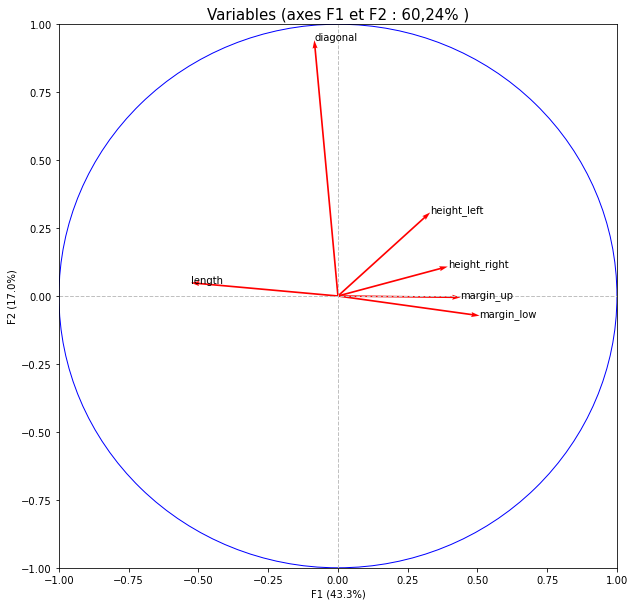

In [59]:
# Cercle des corrélations
# Représentons le Cercle des corrélations de nos variables
pcs = pca.components_

fig = plt.subplots(figsize=(10,10))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
           pcs[0,:], pcs[1,:], 
           angles='xy', scale_units='xy', scale=1, color='r', width= 0.003)

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.text(x, y, data_pca.columns[i])
    
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

#Ajout des axes
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)

plt.title('Variables (axes F1 et F2 : 60,24% )', fontsize=15)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))

plt.show()

Les variables majeures qui contribuent au facteur (F1) sont : 

    _ Length
    _ Height_left  
    _ Height_right
    _ Margin_up   
    _ Margin_low
    
    
*Les variables height_left et height_right contribuent le plus et positivement à l'axe 1.*

*Les variables margin_up et margin_low contribuent positivement à l'axe 1.*

*La variable lenght contribue négativement à l'axe 1.*

Les variables majeures qui contribuent au facteur (F2) sont : 

    _ Diagonal
    
   *La variable diagonal contribue fortement (et positivement) à l'axe 2*
    

#### I.2.3  Matrice de corrélation

Il est maintenant possible de représenter les données sur le premier plan factoriel. Dans ce graphique, il est important de noter le pourcentage de variance expliquée.

Dans un premier temps affichons la matrice de corrélation

In [60]:
# nb individus
n = X_scaled.shape[0] 
# nb variables
p = X_scaled.shape[1] 

In [61]:
# valeurs propres
eigval = (n-1) / n * pca.explained_variance_ratio_ # valeurs propres
# racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval) 

In [62]:
# matrice vide pour avoir les coordonnées
corvar = np.zeros((6,p)) 
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]

In [63]:
coordvar = pd.DataFrame({'Variables': data_pca.columns, 'FACTEUR1': corvar[:,0], 'FACTEUR2': corvar[:,1]})
coordvar.index=coordvar['Variables']

In [64]:
del coordvar['Variables']

In [65]:
coordvar

,FACTEUR1,FACTEUR2
Variables,,
diagonal,-0.055707,0.387485
height_left,0.217464,0.126593
height_right,0.258849,0.044594
margin_low,0.333919,-0.029820
margin_up,0.289011,-0.002039
length,-0.346652,0.020021


<AxesSubplot:ylabel='Variables'>

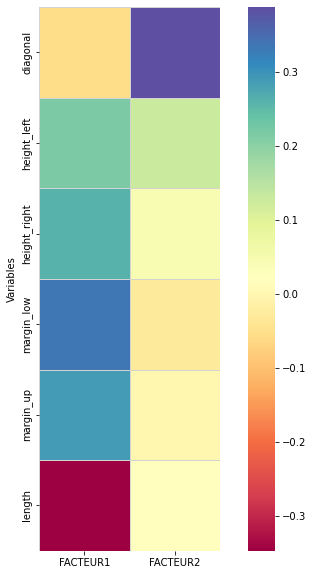

In [66]:
# matrice de corréclation
plt.figure(figsize=(10,10)) 
sns.heatmap(coordvar, cmap='Spectral', square=True , linecolor="lightgray", linewidths=1)

#### I.2.4 Graphique des observations 

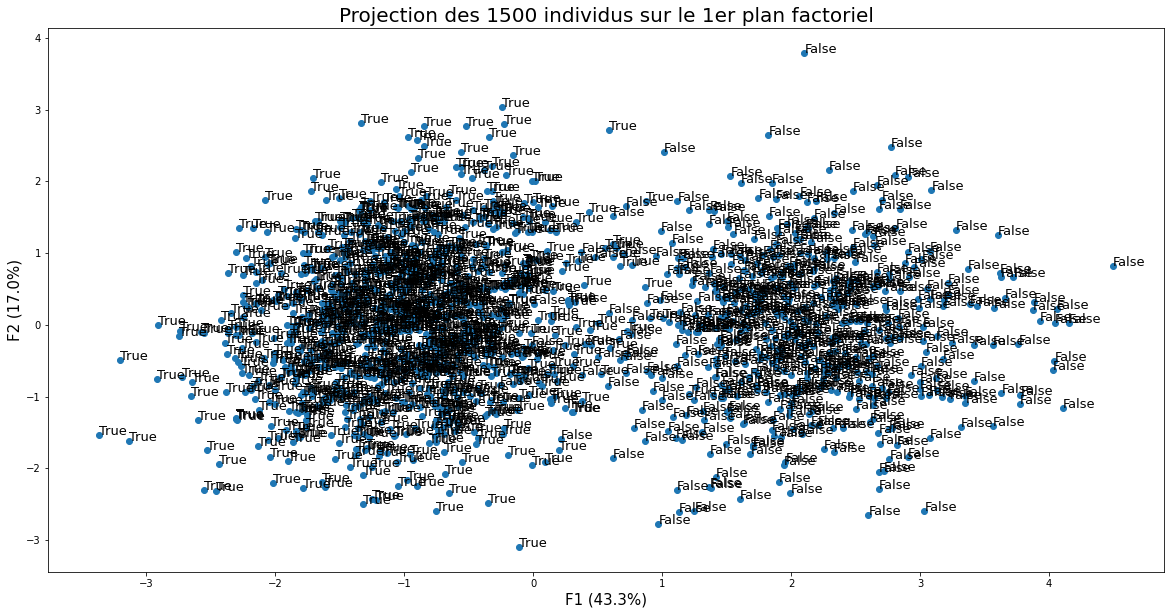

In [67]:
#Projection des  individus sur le premier plan factoriel (F1, F2)

#Coordonnées factorielles 

X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 10))


plt.scatter(X_projected[:, 0], X_projected[:, 1])
for i,(x,y) in enumerate(X_projected[:,[0,1]]):
                    plt.text(x, y, data.index [i], fontsize='13') 

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)), fontsize=15)
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)), fontsize=15)
plt.title("Projection des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]), fontsize=20)

plt.show()

*On voit clairement deux nuages distincts et quelques outliers*

*Les vrais billets (True) inférieur à 0,5*

*Les faux billets (False) supérieur à 0,5*

### II.  Application de l'algorithme du K-Means

####  II.1. Choix du nombre approprié de clusters

Dans cette section, nous allons examiner deux méthodes couramment utilisées pour évaluer le nombre approprié de clusters :

La méthode du coude et
Le coefficient de silhouette

Nous allons maintenant réaliser un clustering K-Means pour plusieurs tailles de clusters, et pour chacune de ces tailles nous allons calculer le coefficient de silhouette, puis l'inertie pour pouvoir ensuite choisir la taille de cluster la plus appropriée. 

La méthode de coude nous aidera a conclure sur ce point.

In [68]:
#Préparation des données pour le clustering K-Means
X = billets_avec_isgenuine.values

In [69]:
#Centrage / réduction des données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

####  III.1.1 La méthode de silhouette 

La méthode de silhouette est une méthode pour trouver le nombre optimal de clusters. Le coefficient de silhouette est une mesure de la similitude d’un point de données à l’intérieur d’un groupe par rapport à d’autres groupes.

Ce coefficient doit être calculer pour chaque point du jeu de données. Pour trouver ce coefficient du i-ème point :

On commence par calculer 
 : la distance moyenne de ce point avec tous les autres points dans les mêmes clusters.
Ensuite, on calcule 
 : la distance moyenne de ce point avec tous les points du cluster le plus proche de son cluster.
Finalement, on calcule 
 (coefficient de silhouette) pour ce i-ème point en utilisant la formule ci-dessous.
 
 

On choisira une plage de valeurs 
 candidates, puis on lancera l'algorithme k-means pour ces valeurs de 
 en calculant à chaque fois le coefficient de silhouette moyen.

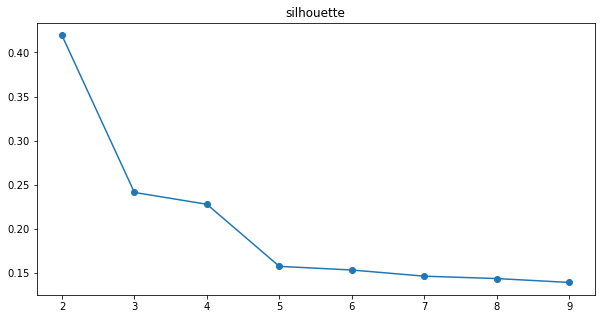

In [70]:
#Calcul de la métrique "silhouette" pour différents nombres de groupes issus de la méthode des centres mobiles
#Liste pour stocker nos coefficients

fig =plt.figure(figsize=(10,5))

silhouettes = [] 

#Boucle itérative de 1 à 10 pour tester les possibilités
for k in range(2, 10): 
    #Création et ajustement d'un modèle pour chaque k
    cls = cluster.KMeans(n_clusters=k)  
    cls.fit(X_scaled)
    
    #Stockage des coefficients associés
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)
    
#Visualisation des valeurs de coefficient de silhouette pour chaque nombre de cluster
plt.title("silhouette")
plt.plot(range(2, 10), silhouettes, marker='o')
plt.show()

*On remarque que le coefficient de silhouette est maximal pour 
2 , le nombre de clusters adéquats dans ce cas alors est 2*

####  III.1.2 La méthode d’Elbow

Selon l’algorithme de K-Means, on doit définir au préalable le nombre K de clusters. Le problème qui se pose et de trouver un K optimal. L’une des méthodes les plus populaires pour y arriver est la méthode d’Elbow.

Lorsque l’on trace les distorsions et que le tracé ressemble à un bras, le « coude » (le point d’inflexion de la courbe) est la meilleure valeur de k.

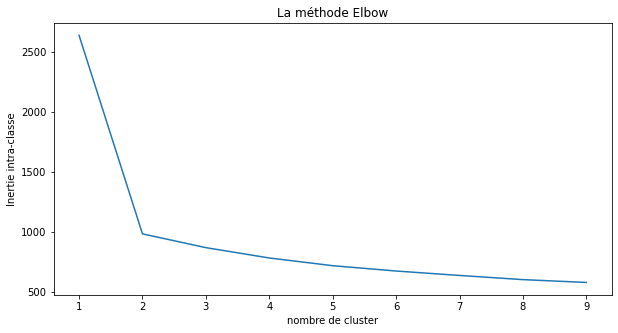

In [71]:
#Détermination de la valeur optimale de K avec la méthode Eblow
fig =plt.figure(figsize=(10,5))
tab=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(billets_avec_isgenuine)
    tab.append(kmeans.inertia_)
plt.plot(range(1,10),tab)
plt.title("La méthode Elbow")
plt.xlabel("nombre de cluster")
plt.ylabel("Inertie intra-classe")
plt.show()

*Le point d’inflexion de la courbe ici se trouve au niveau de 2.*

*Le nombre de clusters adéquats dans ce cas alors est 2.*

####  II.2.  Projection ds clusters

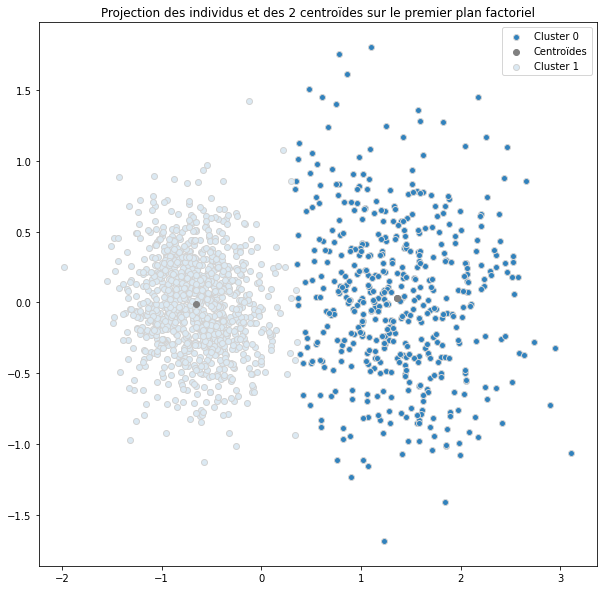

In [72]:
# Nombre de clusters souhaités
n_clust = 2

# import de l'échantillon
data = billets_avec_isgenuine[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]

# préparation des données pour le clustering
X = data.values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
# X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
#pca = decomposition.PCA(n_components=3).fit(X)
#X_projected = pca.transform(X)
#plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
#plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
#plt.show(block=False)


centroids_km = km.cluster_centers_

# Clustering par projection des individus sur le premier plan factoriel:
pca_km = decomposition.PCA(n_components=3).fit( billets_avec_isgenuine[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = decomposition.PCA(n_components=3).fit_transform( billets_avec_isgenuine[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

centroids_km_projected = pca_km.transform(centroids_km)

# Graphique:
fig =plt.figure(figsize=(10,10))
for couleur,k in zip(["#3182bd","#dbe9f3"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],acp_km[km.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="grey",label="Centroïdes")
plt.title("Projection des individus et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)))
plt.show()


le Kmeans a regroupé les données similaires en classes 

*- la classe 0 qui correspond aux vrais billets*

*- la classe 1 qui correspond aux faux billets*

On peut observer certains billets qui flirtent de part et d'autres

*Python attribue la valeur 0 aux valeurs négatives et 1 aux valeurs positives*

#### II.3. Matrice de confusion

La matrice de confusion est en quelque sorte un résumé des résultats de prédiction pour un problème particulier de classification. Elle compare les données réelles pour une variable cible à celles prédites par un modèle.

Nous allons dans un premier temps croiser les labels initiaux et les labels des classes kmeans, puis dans un deuxième temps nous ferons une visualisation

In [73]:
#Verification de la classification: Matrice de confusion:
km_matrix = pd.crosstab(clusters,billets_avec_isgenuine["is_genuine"])
km_matrix

is_genuine,False,True
row_0,,
0,481,3
1,19,997


Text(0.5, 1.0, 'Matrice de confusion K-means\n')

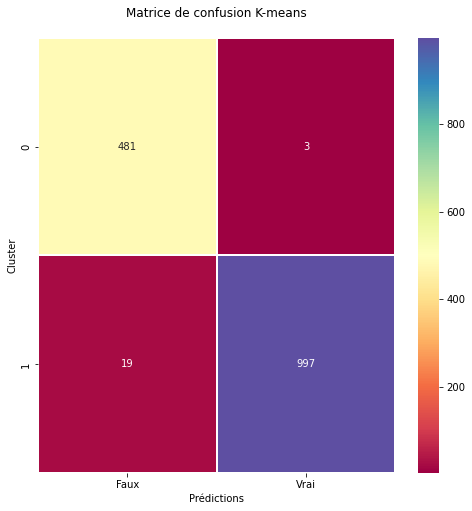

In [74]:
# Graphique:

plt.figure(figsize=(8, 8))
sns.heatmap(km_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("Spectral", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion K-means\n")

Après avoir croiser les labels initiaux et les labels des classes kmeans on observe :

*- Pour la classe des faux billets (classe 0) qu'il existe 481 faux billets et 19 faux billets identifiés avec les vrais billets (classe 1)*

*- Pour la classe des Vrais billets (classe 1) qu'il existe 997 vrais billets et 3 vrais billets identifiés avec les faux billets (classe 0)*

#### II.4. Mesures de performance

L’accuracy, le recall et la precision sont des indicateurs  à utiliser ensemble pour donner une vision complète de la performance. On cherche à avoir des valeurs le plus proche possible de 100% pour les 3 indicateurs. Selon les cas, on choisira parfois de maximiser le recall plutôt que la precision ou vice versa. Cela dépend du projet.

#### II.4.1 Accuracy 

L’accuracy ((taux de bonne classification)) indique le pourcentage de bonnes prédictions.Vrai positif et Vrai négatif sur l'ensemble.

Ratio de prédictions justes. C'est une bonne mesure si le jeu de données est symétrique et si les faux positifs et faux négatifs ont la même importance/le même poid. Accuracy = TP+TN/total

In [75]:
accuracy_score(clusters,billets_avec_isgenuine["is_genuine"])

0.9853333333333333

*Le taux de reussite du modèle est de 98,5 %. Le taux d'erreur 1,5 % est très faible*

*Le modèle est précis à 98,5 % pour faire une bonne prédiction.*

#### II.4.2 Precision

La précision est calculée comme le rapport entre le nombre d' échantillons positifs correctement classés et le nombre total d'échantillons classés comme positifs (correctement ou incorrectement). La précision mesure l'exactitude du modèle à classer un échantillon comme positif.

L'objectif de la précision est de classer tous les échantillons Positifs comme Positifs , et de ne pas mal classer un échantillon négatif comme Positif

Ratio de vrais positifs sur le total des prédictions positives. Precision = TP/TP+FP

In [76]:
precision_score(clusters,billets_avec_isgenuine["is_genuine"])

0.997

*Le modèle est précis à 99 % lorsqu'il indique qu'un billet est faux.*

#### II.4.3 Recall

Le rappel est calculé comme le rapport entre le nombre d' échantillons positifs correctement classés comme positifs et le nombre total d' échantillons positifs . Le rappel mesure la capacité du modèle à détecter les échantillons positifs . Plus le rappel est élevé, plus les échantillons positifs détectés sont nombreux.

Qu'est-ce que cela signifie lorsque le rappel est haut ou bas ? Lorsque le rappel est élevé, cela signifie que le modèle peut classer correctement tous les échantillons positifs en tant que Positif . Ainsi, on peut faire confiance au modèle dans sa capacité à détecter des échantillons positifs.

In [77]:
recall_score(clusters,billets_avec_isgenuine["is_genuine"])

0.9812992125984252

*Le modèle a correctement classé 98 % des échantillons positifs* 

*Cet indicateur nous montre  que la capacité à indentifier les faux billet des vrais est élevé voire quasi parfaite.*

### Quatrième Partie - Régression logistique

Modélisez les données à l'aide d'une régression logistique. Grâce à celle-ci, vous créerez un programme capable d'effectuer une prédiction sur un billet, c'est-à-dire de déterminer s'il s'agit d'un vrai ou d'un faux billet. Pour chaque billet, votre algorithme de classification devra donner la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.

L'objectif de la régression logistique est de modéliser, de classifier, une variable binaire prenant ses valeurs dans {0,1}
 en fonction de variables explicatives quantitatives (et potentiellement qualitatives). La régression logistique est une méthode de classification (supervisée)

Nous cherchons à mettre en place un modèle prédictif à l'aide de données annotées, le but étant d'expliquer une variable qualitative binaire (Vrai/faux) par des variables aléatoires quantitatives (mesures en millimètre), il faut donc faire une régression logistique. On commence par isoler la variable cible des autres.

La régression logistique est une technique statistique qui a pour objectif, à partir d’un fichier d’observation, de produire un modèle permettant de prédire les valeurs prises par une variable catégorielle, le plus souvent binaire, à partir d’une série des variables explicatives continues et ou catégorielles.

In [78]:
#Comptage des modalites de y
# y (authenticite): 
y_billet =  billets_avec_isgenuine.loc[:, billets_avec_isgenuine.columns == "is_genuine"]
y_billet.value_counts()                                  

#Il faut ajouter une constante dans Statsmodels
# X (les autres):
X_billet = billets_avec_isgenuine.loc[:, billets_avec_isgenuine.columns != "is_genuine"]
X_billet = sm.tools.add_constant(X_billet)                      
X_billet.head()

C:\Users\moust\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


In [79]:
# Affichons les "y_billet"
y_billet

,is_genuine
0,True
1,True
2,True
3,True
4,True
...,...
1495,False
1496,False
1497,False
1498,False


In [80]:
# Affichons les "x_billets"
X_billet

,const,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,1.0,171.75,104.38,104.17,4.42,3.09,111.28
1496,1.0,172.19,104.63,104.44,5.27,3.37,110.97
1497,1.0,171.80,104.01,104.12,5.51,3.36,111.95
1498,1.0,172.06,104.28,104.06,5.17,3.46,112.25


####  I.1. Importation des données

#### I.1.1 Modèle de regression Logit

In [81]:
# Regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Calculs:
res_log = reg_log.fit()

# Resume des resultats:
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.028228
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Tue, 21 Mar 2023   Pseudo R-squ.:                  0.9557
Time:                        06:52:05   Log-Likelihood:                -42.342
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -204.5582    241.768     -0.846      0.398    -678.415     269.299
diagonal         0.068

In [82]:
# On ne garde que les variables significatives a alpha = 5% dans X_Billet:
X_billet = billets_avec_isgenuine[["height_right","margin_low", "margin_up", "length"]]
X_billet = sm.add_constant(X_billet)

# On recommence la regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Creation du modele:
model_reg_log = reg_log.fit()

# Resume des resultats:
print(model_reg_log.summary2())

Optimization terminated successfully.
         Current function value: 0.029058
         Iterations 12
                         Results: Logit
Model:                Logit            Pseudo R-squared: 0.954   
Dependent Variable:   is_genuine       AIC:              97.1726 
Date:                 2023-03-21 06:52 BIC:              123.7387
No. Observations:     1500             Log-Likelihood:   -43.586 
Df Model:             4                LL-Null:          -954.77 
Df Residuals:         1495             LLR p-value:      0.0000  
Converged:            1.0000           Scale:            1.0000  
No. Iterations:       12.0000                                    
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
const        -323.4452 139.5320 -2.3181 0.0204 -596.9229 -49.9675
height_right   -2.7839   1.0779 -2.5827 0.0098   -4.8965  -0.6712

C:\Users\moust\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


*Après avoir retirer les deux variables non significatives (à savoir 'diagonal' et 'height_left') on a un R2 de 95,4 % contre 95,57 %. Le modèle est plus performant avec toutes nos variables.*

In [83]:
# Test binarite:
print(billets_avec_isgenuine["is_genuine"].nunique())

2


*Il n'y a bien que deux valeurs possibles pour la variable prédite.*

#### I.1.2 Application du modèle

La fonction Python predict() nous permet de prédire les étiquettes des valeurs de données sur la base du modèle formé. La fonction predict() n'accepte qu'un seul argument qui correspond généralement aux données à tester.

In [84]:
# Application du modele sur les donnees training:
billets_avec_isgenuine["proba"] = model_reg_log.predict(X_billet)
billets_avec_isgenuine["y_pred"] = (model_reg_log.predict(X_billet) >= 0.5).astype(int)
billets_avec_isgenuine.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred
0,True,171.81,104.86,104.95,4.52,2.89,112.83,0.939837,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,0.999989,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,0.999873,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,0.999999,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,0.883749,1


#### I.1.3 Evaluation du modèle

In [85]:
X = billets_avec_isgenuine.drop(['is_genuine'], axis=1).values
y = billets_avec_isgenuine['is_genuine']

logistic = LogisticRegression()
logistic.fit(X,y)

LogisticRegression()

In [86]:
billets_avec_isgenuine['prediction']=logistic.predict(X)

#### II. Matrice de confusion

La matrice de confusion est en quelque sorte un résumé des résultats de prédiction pour un problème particulier de classification. Elle compare les données réelles pour une variable cible à celles prédites par un modèle.

Nous allons dans un premier temps croiser les données réelles pour une variable cible à celles prédites, puis dans un deuxième temps nous ferons une visualisation.

#### II.1 Crosstab

In [87]:
predictions = pd.crosstab(billets_avec_isgenuine['is_genuine'],billets_avec_isgenuine['prediction'])
predictions

prediction,False,True
is_genuine,,
False,492,8
True,3,997


#### II.2 Visualisation

Text(0.5, 1.0, 'Matrice de confusion de la regression logistique\n')

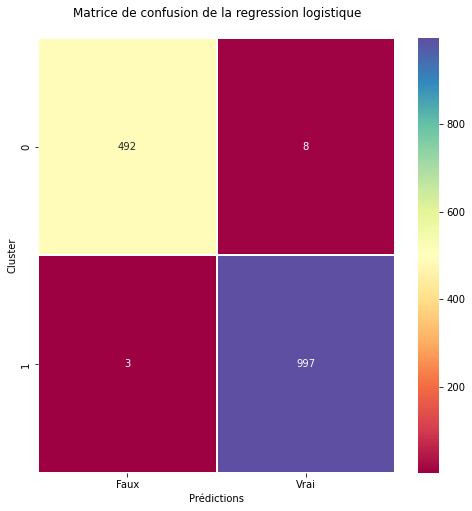

In [88]:
# Matrice de confusion:

# Graphique:

plt.figure(figsize=(8, 8))
sns.heatmap(predictions,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("Spectral", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion de la regression logistique\n")

Après avoir croiser les données réelles pour une variable cible à celles prédites on observe :

*- Pour la classe des faux billets (classe 0) qu'il existe 492 faux billets et 3 faux billets identifiés avec les vrais billets (classe 1)*

*- Pour la classe des Vrais billets (classe 1) qu'il existe 997 vrais billets et 8 vrais billets identifiés avec les faux billets (classe 0)*

#### III. Indicateurs de mesures de performance

#### III.1 Métriques

#### III.1.1 Accuracy

In [89]:
accuracy_score(billets_avec_isgenuine["is_genuine"], billets_avec_isgenuine["y_pred"])

0.9926666666666667

*Le taux de reussite du modèle est de 99 %. Le taux d'erreur 1 % est très faible*

*Le modèle est précis à 99 % pour faire une bonne prédiction.*

#### III.1.2 Precision

In [90]:
precision_score(billets_avec_isgenuine["is_genuine"], billets_avec_isgenuine["y_pred"])

0.9920398009950249

*Le modèle est précis à 99 % lorsqu'il indique qu'un billet est faux.*

#### III.1.3 Recall

In [91]:
recall_score(billets_avec_isgenuine["is_genuine"], billets_avec_isgenuine["y_pred"])

0.997

*Le modèle a correctement classé 99 % des échantillons positifs* 

*Cet indicateur nous montre  que la capacité à indentifier les faux billet des vrais est élevé voire quasi parfaite.*

#### III.1.4 F1 score

In [92]:
recall_score(billets_avec_isgenuine["is_genuine"], billets_avec_isgenuine["y_pred"])

0.997

*Notre modèle est quasiment parfait puisque tous les scores s'approchent de 1. Ce n'est pas très réaliste, mais cela prouve qu'il fonctionne.*

#### III.2 Odds Ratios

Le rapport des chances, rapport des cotes ou risque relatif rapproché (odds ratio en anglais, OR en abrégé) est un outil statistique/épidémiologique qui peut être utilisé pour montrer les associations entre deux variables binaires

In [93]:
# Odds Ratios:
print("Les Odds ratio sont:\n", np.exp(res_log.params))
# utile pour parler en terme de risque

Les Odds ratio sont:
 const           1.450479e-89
diagonal        1.070365e+00
height_left     1.797429e-01
height_right    1.045184e-01
margin_low      3.102473e-03
margin_up       3.895702e-05
length          3.697772e+02
dtype: float64


#### III.3 Courbe R.O.C

La courbe ROC permet de décrire la performance d’un modèle à travers deux indicateurs : la sensitivity et la specificity. L’aire sous cette courbe, nommée AUC ROC, mesure de façon globale la performance d’un modèle de classification.

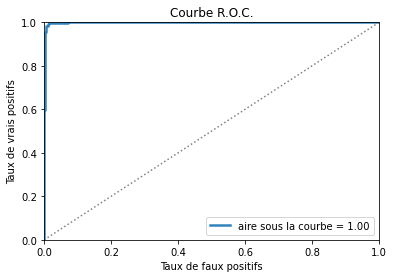

In [94]:
# Courbe R.O.C.:
fpr, tpr, _ = roc_curve(billets_avec_isgenuine["is_genuine"],billets_avec_isgenuine["proba"])
roc_auc = roc_auc_score(billets_avec_isgenuine["is_genuine"],billets_avec_isgenuine["proba"])

# Graphique:
plt.title("Courbe R.O.C.")
plt.plot(fpr,
        tpr,
        color="#3182bd",
        linewidth=2.5,
        label="aire sous la courbe = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1],color="grey", linestyle=":")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = "lower right")
plt.ylabel("Taux de vrais positifs")
plt.xlabel("Taux de faux positifs")
plt.show()

Comme avec les indicateurs calculés plus haut, on retombe sur un modèle quasiment parfait avec une aire sous la courbe approximée à 1.

Le modèle est parfait

#### III.4 Application du modèle aux données - Prédire les valeurs

In [95]:
# Prediction sur des donnes inconnues:
X_test = billets_prod[["height_right","margin_low","margin_up","length"]]
X_test = sm.add_constant(X_test)
billets_prod["proba"] = model_reg_log.predict(X_test)
billets_prod["y_pred"] = (model_reg_log.predict(X_test) >= 0.5).astype(int)
print(billets_prod[["id","proba","y_pred"]])

# Affichage des resultats:
print("\nIndetification des billets:")
for i, k in zip(billets_prod["y_pred"],billets_prod["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"Vrai billet")
    else:
        print("Le billet","{}".format(k),"Faux billet")

    id     proba  y_pred
0  A_1  0.000041       0
1  A_2  0.000003       0
2  A_3  0.000019       0
3  A_4  0.996708       1
4  A_5  0.999988       1

Indetification des billets:
Le billet A_1 Faux billet
Le billet A_2 Faux billet
Le billet A_3 Faux billet
Le billet A_4 Vrai billet
Le billet A_5 Vrai billet


C:\Users\moust\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [96]:
X_test

,const,height_right,margin_low,margin_up,length
0,1.0,103.54,5.21,3.30,111.42
1,1.0,104.13,6.00,3.31,112.09
2,1.0,104.29,4.99,3.39,111.57
3,1.0,104.34,4.44,3.03,113.20
4,1.0,103.56,3.77,3.16,113.33


###  Conclusion 

*Nous n'avions plus assez de temps, mais il est possible d'équilibrer les classes et d'appliquer la régression* 

Lorsqu'il ya une très grande différence entre le nombre d'observations dans chaque catégorie de la variable cible à prédire, cela peut entrainer des erreurs de modélisation. Dans notre cas, il ya 67 % de vrais billets et 33 % de faux billets. Il ya donc un très grand déséquilibre des classes.

Nous pouvons créer le rééchantillonage pour créer plus d'équilibre entre les catégories de la variable cible. Soit on créé plus d'observasions dans la classe minoritaire, c'est-à-dire on fait un *suréchantillonage* soit on diminue les observations de la classe majoritaire c'est-à-dire un *sous-échantillonage*.

#### I. Rééquilibrage des classes

In [97]:
# import random 
from random import sample

In [98]:
billets_avec_isgenuine['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

*Il y a 500 billets marqués comme faux et près de 1 500 ne sont pas faux.* 

Visualisons

C:\Users\moust\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Repartition des billets'}, xlabel='is_genuine', ylabel='count'>

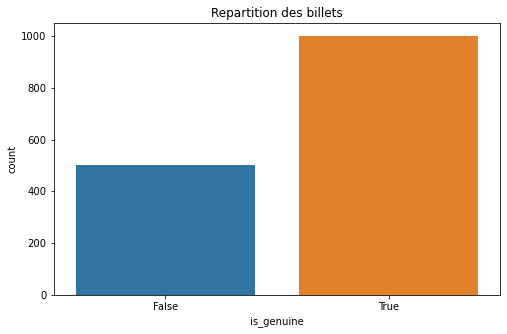

In [99]:
plt.figure(figsize=(8,5)) 
plt.title('Repartition des billets') 
sns.countplot('is_genuine', data=billets_avec_isgenuine)

Le nombre de faux billets est petit par rapport aux vrais. Dans ce cas, on peut sous-échantillonner la classe majoritaire (True) en sélectionnant aléatoirement 500 observations (nombre d'observations en classe minoritaire).

#### I.1 Sur- échantillonage

In [100]:
from sklearn.utils import resample

C:\Users\moust\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


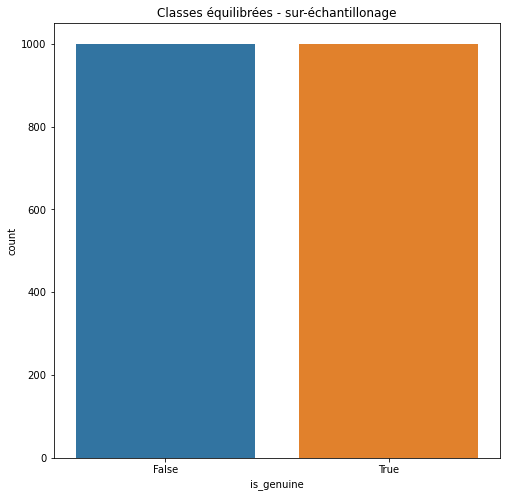

In [101]:
# Méthode de sur-échantillonage de la classe minoritaire

minority = billets_avec_isgenuine[billets_avec_isgenuine.is_genuine == False]
majority = billets_avec_isgenuine[billets_avec_isgenuine.is_genuine == True]
minority_upsampled = resample(minority, replace = True, n_samples = len(majority), random_state=42)
upsampled = pd.concat([majority, minority_upsampled])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot("is_genuine", data=upsampled)
plt.title('Classes équilibrées - sur-échantillonage')
plt.show()


In [102]:
upsampled['is_genuine'].value_counts(normalize=True)

True     0.5
False    0.5
Name: is_genuine, dtype: float64

#### I.2 Sous-échantillonage

C:\Users\moust\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


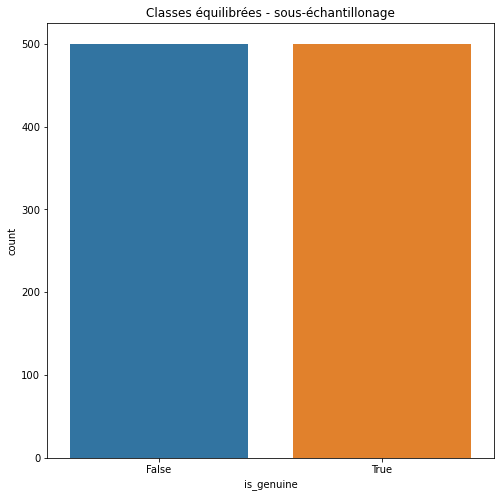

In [103]:
majority_downsampled = resample(majority, replace=False, n_samples= len(minority), random_state=42)
downsampled = pd.concat([minority, majority_downsampled])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot("is_genuine", data=downsampled)
plt.title('Classes équilibrées - sous-échantillonage')
plt.show()

Les étapes que nous avons exécutées :

Mélangez l'intégralité de l'ensemble de données à l'aide de la fonction d'exemple et séparez les classes en filtrant la trame de données.
Sélectionnez au hasard 500 lignes de données non frauduleuses à l'aide de la fonction d'échantillonnage.
Combinez les deux dataframes avec la fonction concat .
À la fin, nous avons une base de données sous-échantillonnée avec une distribution de classe égale.

In [104]:
downsampled['is_genuine'].value_counts(normalize=True)

False    0.5
True     0.5
Name: is_genuine, dtype: float64

### Export du modèle pour l’utiliser dans un autre notebook

*Une fonction a été créée en vue de prédire le type de billet dans un autre notebook*

In [105]:
import pickle

In [106]:
pickle.dump(model_reg_log, open('model_reg_log.pkl','wb'))